# Pipeline to Analyse Super Resolution Single Molecule 2D data 

Supervisor - Alfonso Brenlla-Lopez, Paolo Annibale  
Written by - Alfonso Brenlla-Lopez, Laila Deen

This pipeline is designed to quantify the localisation accuracy of single molecules in microscopy data. It utilizes Python-based scripts to process TIFF-based microscopy images and calculate precision metrics based on Mortensen's formula

 https://github.com/ldeen22/Quantifying-Localisation-of-Single-Molecules.git

In [8]:
# load modules functions

import os
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='afmhot')

%matplotlib notebook
import matplotlib.pyplot as plt

# plots are interactive (you can use zoom and pan)

from skimage.feature import corner_peaks
from skimage.util import view_as_windows
from scipy.ndimage import minimum_filter, gaussian_filter

import skimage.io as skio

import ipywidgets as ipw

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})



To view your own microscopy data, replace the movie "emccdmelted.tif" with your file name in the following line of code:

file_name = os.path.join(root_folder, "emccdmelted.tif")

In [9]:
# load microscopy data
import random
root_folder = os.getcwd()
file_name = os.path.join(root_folder, "emccdmelted.tif")

img_stack = skio.imread(file_name)

### Background subtraction

In [10]:
WINDOW = 15 # pixel dimension
win_2 = WINDOW//2 
pix = np.arange(-win_2, win_2+1) #defines the pixel region

def gaussian_2D(sigma, pix): # this Gaussian is symmetric
    gauss_1D = np.exp(-(pix**2)/sigma)      
    return np.outer(gauss_1D, gauss_1D)
    
sigma = 3.5
kernel = gaussian_2D(sigma, pix)

## Detection of peaks, use only 1st frame

This code segment defines a function `detect_gauss_corr` responsible for detecting peaks in a stack of images using Gaussian correlation. The function takes two parameters: `imgs`, representing the stack of images, and `sigma`, which denotes the standard deviation for Gaussian filtering. Within the function, the mean and standard deviation of pixel intensities across all frames in the image stack are computed. Next, Gaussian filtering is applied to each frame in the stack, followed by the detection of corner peaks using specified criteria such as minimum distance, threshold, and border exclusion. The function returns a list of detected peaks for each frame in the stack, along with the standard deviation of pixel intensities across the stack. After calling the function with the image stack as input, a plot is generated to visualize the first frame along with the detected peaks. The plot is interactive, allowing users to navigate through frames using a slider. Finally, the first frame of the image stack is saved as a PNG image named 'movie_stack.png'.


In [11]:
def detect_gauss_corr(imgs):
    img_mean = imgs.mean(axis=(1,2)) #defines mean for (1024,1024) axis (1,2) for all 200 frames
    img_std = np.std(imgs, axis=(1,2))
    width = (sigma/2)**0.5
    peaks = []
    for idx, img in enumerate(imgs):
        corr_img = gaussian_filter(imgs[idx], width )
        pks = corner_peaks(corr_img, min_distance=WINDOW*2,
                           threshold_abs=img_mean[idx]+img_std[idx]*3, exclude_border=WINDOW)
        peaks.append(pks)
    return peaks 

peaks = detect_gauss_corr( img_stack[0][None, :, :])
peaks = peaks[0]

In [12]:
(img_stack[0][None, :, :]).shape

(1, 512, 512)

In [13]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.feature import corner_peaks

def detect_gauss_corr(imgs, sigma):
    img_mean = imgs.mean(axis=(1,2))
    img_std = np.std(imgs, axis=(1,2))
    width = (sigma/2)**0.5
    peaks = []
    for idx, img in enumerate(imgs):
        corr_img = gaussian_filter(imgs[idx], width)
        pks = corner_peaks(corr_img, min_distance=WINDOW*2,
                           threshold_abs=img_mean[idx]+img_std[idx]*3, exclude_border=WINDOW)
        peaks.append(pks)
    return peaks, img_std

peaks, img_std = detect_gauss_corr(img_stack[0][None, :, :], sigma)
peaks = peaks[0]
print("Standard deviation:", img_std)


Standard deviation: [1295.13]


<IPython.core.display.Javascript object>


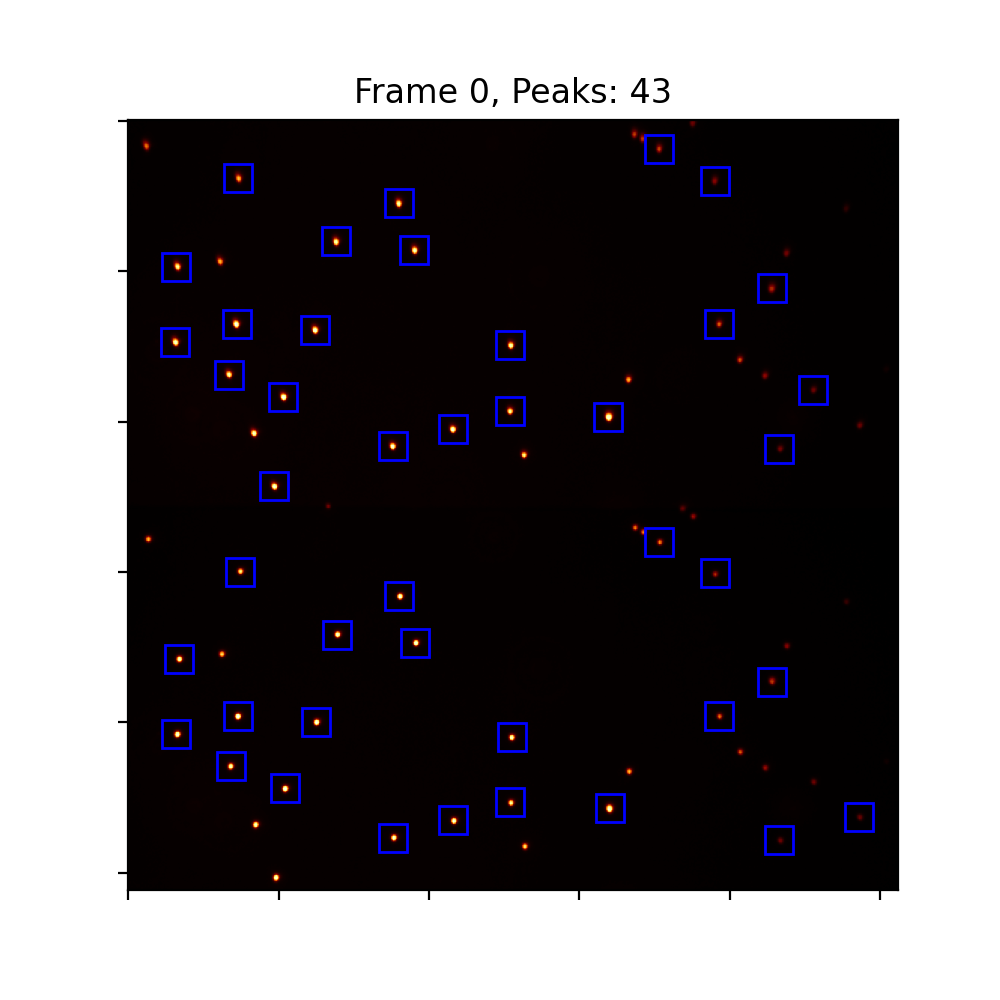

interactive(children=(IntSlider(value=0, description='n', max=199), Output()), _dom_classes=('widget-interact'…

In [14]:
# Explore all frames
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(5,5) ) #empty plot

im_data = ax.imshow(img_stack[0]) #append 1st frame to plot
peaks_line, = ax.plot(peaks.T[1], peaks.T[0], 's', color='b', markerfacecolor='None', markersize=10) #plotting peaks
ax.set_xticklabels([])
ax.set_yticklabels([])

def update(n):
    im_data.set_data(img_stack[n])
    #im_data.set_clim(vmin=min_vals[n], vmax=max_vals[n])
    #peaks_line.set_xdata(peaks[n].T[1])
    #peaks_line.set_ydata(peaks[n].T[0])
    
    num_peaks = len(peaks.T[n])
    ax.set_title(f"Frame {n}, Peaks: {num_peaks}")

    fig.canvas.draw_idle()

ipw.interact(update, n=ipw.IntSlider(min=0, max=img_stack.shape[0]-1, step=1));

plt.imsave('movie_stack.png', img_stack[0], cmap='gray')

Into the "num_peaks" definition, insert the number of peaks as stated in the image above

In [15]:
num_peaks = 43

## Fitting ROIs to 2D Gaussian Function

Now that the detection part is completed, the subsequent cells focus on fitting these regions of interest (ROIs) to a 2D Gaussian function. The variable `peaks` is a list containing peaks detected in each frame of the image stack, with a length corresponding to the number of frames. The function `get_rois_from_peaks` extracts ROIs centered around these peaks from the image stack. Each ROI is defined as a subregion of the image, with dimensions determined by the `win_2` parameter. Next, several functions are defined to compute the Gaussian, its derivatives with respect to parameters, and linear coefficients. These functions are utilized in the `compute_fit_manual_inv` function to fit a 2D Gaussian to the ROIs. The Levenberg-Marquardt algorithm (`lev_marq`) is employed for iterative optimization of the Gaussian parameters. After defining necessary arrays and matrices, the algorithm iteratively updates the Gaussian parameters until convergence, adjusting them based on the fit to the data. The resulting Gaussian fits are compared to the original data using matplotlib visualization. Each frame's ROI data and its corresponding Gaussian fit are displayed side by side, allowing for visual assessment of the fitting quality. Users can interactively navigate through frames using a slider to observe variations in the fits. Finally, the code concludes with a bioinformatics tool to annotate sequences in GenBank format. 

In [16]:
# peaks is a list with lenght n_frames
#ROIS - region of interest

def get_rois_from_peaks(imgs, peaks):
    rois = [] #empty set
    for frame in imgs: #iterating over 200 frames
        for idx in peaks: #iterating over the 10 peaks
            rois.append(frame[idx[0]-win_2:idx[0]+win_2+1, idx[1]-win_2:idx[1]+win_2+1] ) 
    return rois
#indexing over peaks minusing -7 to 7+1. 
rois = get_rois_from_peaks(img_stack, peaks)


Define functions that compute the Gaussian, its derivative with respect to parameters and the linear coefficients

<IPython.core.display.Javascript object>


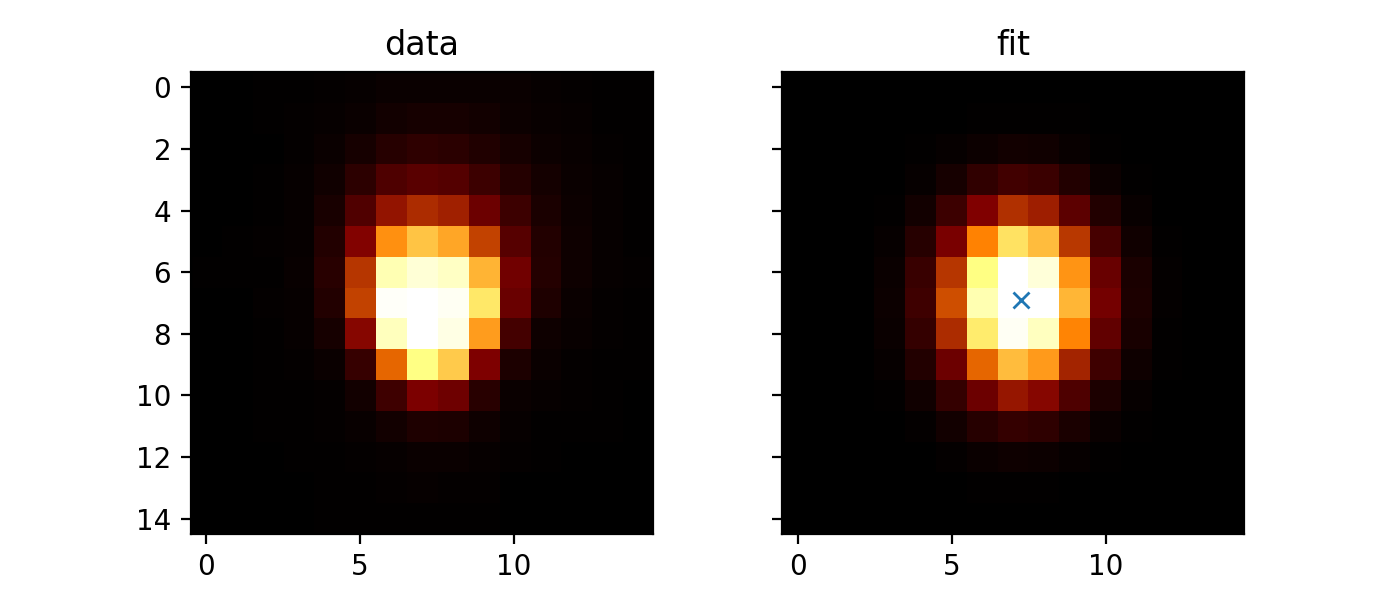

interactive(children=(IntSlider(value=0, description='n', max=8599), Output()), _dom_classes=('widget-interact…

In [17]:
DTYPE = np.float32

def gaussian_stack_out(start, x):
    """modifies gaus_stack in-place"""
    
    x0, varx, y0, vary  = start.T
    x0, varx, y0, vary  = x0[:,None,None], varx[:,None,None], y0[:,None,None], vary[:,None,None]
    # shape (n_psf, 1, 1)
    
    x_exponent = (x.T[None,...] - x0)/varx  # shape (n_psf, 1, WINDOW)
    y_exponent = (x[None,...] - y0)/vary # shape (n_psf, 7, WINDOW)
    
    x_exponent_sqr = x_exponent**2
    y_exponent_sqr = y_exponent**2

    np.matmul(np.exp(-y_exponent_sqr), np.exp(-x_exponent_sqr), out=gaus_stack)
    
    exponents_out[..., 0], exponents_out[..., 1] = x_exponent.reshape(-1,  WINDOW), x_exponent_sqr.reshape(-1,  WINDOW)
    exponents_out[..., 2], exponents_out[..., 3] = y_exponent.reshape(-1,  WINDOW), y_exponent_sqr.reshape(-1,  WINDOW)
    

def gaussian_deriv_out_xy(start, coeff, axis='x'):
    x0, varx, y0, vary  = start.T  
    jac = np.empty([n_psf,  WINDOW,  WINDOW, 2], dtype=DTYPE)
    if axis=='x':
        exponents_out[..., :2] *= -2/varx[:, None, None]
        np.multiply(exponents_out[:, None, :, :2], gaus_stack[..., None], out=jac)
    elif axis=='y':    
        exponents_out[..., 2:] *= -2/vary[:, None, None]
        np.multiply(exponents_out[:, :, None, 2:], gaus_stack[..., None], out=jac)
        
    return jac.reshape(-1,  WINDOW**2, 2)/coeff[:, 0][:,:,None]     

def compute_fit_manual_inv(params, rois_arr):
    """fit a 2D Gaussian to data
    params shape (n_psf, 4)
    rois_arr shape (n_psf, n, n)"""    
    gaussian_stack_out(params, x) # works in-place with global variable gaus_stack 
    design_matrix[..., 0] = gaus_stack.reshape(-1,  WINDOW**2) # shape (n_psf, WINDOW**2, 2)
    a, b = inv_x_det[:, 1, 1], inv_x_det[:, 0, 1] # shape (n_psf,)
    a, b = a[..., None, None], b[..., None, None] # shape (n_psf, 1, 1)
    np.matmul( design_matrix[..., 0][:,None,:], design_matrix[..., 0][:,:,None], out=a)
    np.matmul( design_matrix[..., 0][:,None,:], design_matrix[..., 1][:,:,None], out=b)
    inv_x_det[:, 1, 0] = b.squeeze()
    inv_x_det[:, 0, 0] = float(rois_arr[0].size)
    d = inv_x_det[:, 0, 0]
    neg_mask = np.array( [[False, True], [True, False]] )
    np.negative(inv_x_det, where=neg_mask, out=inv_x_det)
    determinant = a.squeeze()*d-b.squeeze()**2 # shape (n_psf,)
    coeff = inv_x_det@(design_matrix.swapaxes(1,2)@rois_arr.reshape(-1,  WINDOW**2)[...,None])
    coeff /= determinant[:,None,None] # shape (n_psf, 2, 1)
    fit = design_matrix@coeff # shape (n_psf, n**2, 1)
    
    return fit, coeff


def lev_marq(data, start, dampers):
    for damp in dampers:
        fit, coeff = compute_fit_manual_inv(start, data)
        fit = fit.reshape(-1, WINDOW, WINDOW)
        jac_x = gaussian_deriv_out_xy(start, coeff, axis='x') # shape (n_psf, 49, 2)
        delta = np.swapaxes(jac_x, 1, 2)@( (data-fit).reshape(-1,  WINDOW**2, 1) )
        delta = delta.squeeze() # shape (n_psf, 2)
        start[:, :2] -= delta/damp
        fit, coeff = compute_fit_manual_inv(start, data)
        fit = fit.reshape(-1, WINDOW, WINDOW)
        jac_y = gaussian_deriv_out_xy(start, coeff, axis='y') # shape (n_psf, 49, 2)
        delta = np.swapaxes(jac_y, 1, 2)@( (data-fit).reshape(-1,  WINDOW**2, 1) )
        delta = delta.squeeze() # shape (n_psf, 2)
        start[:, 2:] -= delta/damp
    return start


data_arr = np.array(rois, dtype=DTYPE) # shape (n_psf, 15, 15)

n_psf = len(rois)
gaus_stack = np.zeros( (n_psf, WINDOW, WINDOW), dtype=DTYPE)
x = np.arange(-win_2, win_2+1, dtype=DTYPE)[:, None]

design_matrix = np.ones([n_psf, WINDOW**2, 2], dtype=DTYPE) 
inv_x_det = np.empty([n_psf, 2, 2], dtype=DTYPE)

start = np.ones( (n_psf, 4), dtype=DTYPE )
start[:, [0, 2]] = 0

exponents_out = np.zeros([n_psf, WINDOW, 4], dtype=DTYPE)

dampers = np.linspace(1, 2, 20, dtype=DTYPE)

opt_all = lev_marq(data_arr, start, dampers)

# remove nans
#idx_valid = ~np.isnan(opt_all).any(axis=1)
#opt_all = opt_all[idx_valid] # remove nan

n = WINDOW

xy_shift = opt_all[:, [0, 2]]  # shape (n_psf, 2)

# How do fit and data compare?
all_fits, all_coeff = compute_fit_manual_inv(opt_all, data_arr)
all_fits = all_fits.reshape(-1, n ,n)
max_vals = data_arr.max( axis=(1,2) )

fig1, (ax_roi, ax_fit) = plt.subplots( 1, 2, sharex=True, sharey=True, figsize=(7,3) )

im_roi = ax_roi.imshow(data_arr[0], vmax=max_vals[0])
im_fit = ax_fit.imshow(all_fits[0], vmax=max_vals[0])
line_fit, = ax_fit.plot(*xy_shift[0]+win_2, 'x')
ax_roi.set_title('data')
ax_fit.set_title('fit')

def update(n):
    im_roi.set_data(data_arr[n])
    im_roi.set_clim(vmax=max_vals[n])
    im_fit.set_data(all_fits[n])
    im_fit.set_clim(vmax=max_vals[n])
    line_fit.set_data(*xy_shift[n]+win_2)
    fig1.canvas.draw_idle()

ipw.interact(update, n=ipw.IntSlider(min=0, max=data_arr.shape[0]-1, step=1));




# Standard deviation (s) of x,y

After completing the fitting process, attention is turned to calculating the standard deviation (s) of the Gaussian distribution along the x and y axes. The optimized variance values for the x-axis (`varx_optimized`) and y-axis (`vary_optimized`) are extracted from the `opt_all` array, which contains the optimized parameters obtained from fitting. Specifically, column 1 of `opt_all` corresponds to the varx values, while column 3 corresponds to the vary values. The standard deviations (σ) along the x and y axes are then calculated using the square root of the variance values, resulting in arrays `sigma_x` and `sigma_y`, respectively. The mean values of sigma_x and sigma_y across all fitted PSFs are computed using NumPy's `mean` function, yielding `sigma_x_psf` and `sigma_y_psf`. These average standard deviations represent the typical spread of the Gaussian distribution along the x and y axes for the entire dataset. Finally, the overall average standard deviation (`sigma_psf`) is calculated as the square root of the sum of the squares of sigma_x_psf and sigma_y_psf. This average sigma value provides an overall measure of the spread of the Gaussian distribution across both axes, offering insights into the spatial characteristics of the dataset. The computed average sigma values are printed for further analysis and interpretation.


In [28]:
# Extract the optimized varx and vary values from opt_all
varx_optimized = opt_all[:, 1]  # Column 1 contains varx values
vary_optimized = opt_all[:, 3]  # Column 3 contains vary values

# Calculate the standard deviation (σ) along the x-axis and y-axis
sigma_x = np.sqrt(varx_optimized)
sigma_y = np.sqrt(vary_optimized)

#for i in range(len(sigma_x)):
    #print(f"Gaussian Distribution {i + 1}:")
    #print(f"  Sigma_x: {sigma_x[i]}")
    #print(f"  Sigma_y: {sigma_y[i]}")
    #print()
    

In [29]:
sigma_x_psf = np.mean(sigma_x)
sigma_y_psf = mean_value = np.nanmean(sigma_y)
print(f"Average Sigma_x :", sigma_x_psf)
print(f"Average Sigma_y :", sigma_y_psf)

sigma_psf = np.sqrt((sigma_x_psf**2 + sigma_y_psf**2))
print(f"Average Sigma :", sigma_psf)

Average Sigma_x : 1.340359
Average Sigma_y : 1.4477584
Average Sigma : 1.9729588604151762


## Background and Photon count

In this section, the background image is loaded using the `os` module, with file named "background_image.ome.tif".  Next, the photon count per localization and background count per pixel are calculated based on the image and background data. The total photon count per localization (`N`) is estimated by multiplying the mean intensity of the image stack by the area of the region of interest (`WINDOW` squared) and further scaling by a factor of 1.03 which is the sensitivity of our setup. Additionally, the average background count per pixel (`b_2`) is computed as the mean intensity of the background image. 


In [30]:
root_folder = os.getcwd()
background = os.path.join(root_folder, "background_image.ome.tif")
bg_stack = skio.imread(background)

N = (np.mean(img_stack)*WINDOW**2)*1.03
b_2 = np.mean(bg_stack)
print(f"Photon count per localisation :", N)
print(f"Background count per pixel :", b_2)

Photon count per localisation : 250084.6118321371
Background count per pixel : 107.5049638748169


# Mortensen Precision

The section focuses on calculating the Mortensen precision for localizations obtained from Gaussian fitting. The Mortensen precision formula is defined as a function `mortensen_precision`, which takes parameters including the fluorescence intensity (`F`), the standard deviation of the point spread function (`sigma_PSF`), the variance of the background noise (`var_b`), the photon count per localization (`N`), and the pixel size (`a`). The Mortensen precision is computed for each localization along both the x and y axes, providing insight into the localization accuracy. The Mortensen precision values are then calculated for the first 10 Gaussian distributions, corresponding to individual fluorescent beads in the sample. For each bead, the Mortensen precision is determined separately for the x and y axes, highlighting the variability in localization accuracy across different beads. Additionally, an error propagation matrix is constructed to assess the uncertainty in localization accuracy when considering pairs of beads. The matrix is populated with Mortensen precision values computed for all possible pairs of beads, providing a comprehensive assessment of error propagation in the localization process. Finally, the upper triangular part of the error propagation matrix is extracted and printed for analysis, offering insights into the pairwise error propagation between beads in the sample.


In [31]:
a = 400 #40x

def mortensen_precision(F, sigma_PSF, var_b, N, a):
    pi = np.pi
    sigma_a = np.sqrt(sigma_PSF**2*a**2 + (a**2)/12)
    var_x = F * (sigma_a**2 / N) * ((16/9) + (8 * pi) * sigma_a**2 * var_b / (N * a**2))
    return np.sqrt(var_x)

localization_precision = mortensen_precision(2,sigma_psf,b_2,N,a)

In [32]:
# Loop across all Gaussian distributions
for i in range(len(sigma_x)):
    localization_precision_x = mortensen_precision(2, sigma_x[i], b_2, N, a)
    localization_precision_y = mortensen_precision(2, sigma_y[i], b_2, N, a)
    
    #print(f"Gaussian Distribution {i + 1}:")
    #print(f"  Sigma_x: {sigma_x[i]} with localization precision: {localization_precision_x}")
    #print(f"  Sigma_y: {sigma_y[i]} with localization precision: {localization_precision_y}")
    #print()


In [33]:
# Loop across the first 10 Gaussian distributions
for i in range(10):
    localization_precision_x = mortensen_precision(2, sigma_x[i], b_2, N, a)
    localization_precision_y = mortensen_precision(2, sigma_y[i], b_2, N, a)
    
    #print(f"Bead {i + 1}:")
    #print(f"  Sigma_x: {sigma_x[i]} with localization precision: {localization_precision_x}")
    #print(f"  Sigma_y: {sigma_y[i]} with localization precision: {localization_precision_y}")
    #print()


In [34]:
np.set_printoptions(precision=10)  # Adjust the precision as needed
error_propagation_pairs = np.zeros((num_peaks, num_peaks))

for i in range(num_peaks):
    for j in range(i+1, num_peaks):
        localization_precision_x_i = mortensen_precision(2, sigma_x[i], b_2, N, a)
        localization_precision_y_i = mortensen_precision(2, sigma_y[i], b_2, N, a)
        localization_precision_x_j = mortensen_precision(2, sigma_x[j], b_2, N, a)
        localization_precision_y_j = mortensen_precision(2, sigma_y[j], b_2, N, a)
        
        error_propagation_pairs[i, j] = np.sqrt((localization_precision_x_i**2 + localization_precision_y_i**2) +
                                                (localization_precision_x_j**2 + localization_precision_y_j**2))

# Ensure the matrix is symmetric by copying the upper triangular part to the lower triangular part
error_propagation_pairs += error_propagation_pairs.T - np.diag(error_propagation_pairs.diagonal())

# Extract the upper triangular part of the matrix
triangular_indices = np.triu_indices(num_peaks, k=1)
error_propagation_triangular = error_propagation_pairs[triangular_indices]

print("Error Propagation for Bead Pairs:")
print(error_propagation_triangular)


Error Propagation for Bead Pairs:
[4.6224642722 4.6616483633 4.7050158307 4.6312863956 4.5243218072
 4.5261098648 4.5737338783 4.6489778935 4.5049563405 4.5807464613
 4.5190707634 4.6328699006 4.5671513334 4.4803532829 4.4910694234
 4.477526369  4.6666181268 4.5901482684 4.6489503841 4.4990820869
 4.5010594835 4.5953411718 4.4899095374 4.4694830936 4.6697015599
 4.4970060657 4.5523490519 4.4720684758 4.4760647775 4.6995814511
 4.4508961551 4.5952183639 4.466753982  4.6999740916 4.6731933807
 4.8139292626 4.4570307293 4.6864306881 4.5448899697 4.5705585637
 4.5011031903 4.483281665  4.489173643  4.5341910526 4.457637066
 4.3464010801 4.3482623014 4.3978126522 4.4760149674 4.3262392633
 4.4051052969 4.3409348186 4.4592822349 4.3909663898 4.3006139182
 4.3117767915 4.2976687773 4.4943341303 4.4148811604 4.475986395
 4.3201220074 4.322181279  4.4202799707 4.3105686618 4.2892882461
 4.49753568   4.3179599453 4.3755681259 4.2919821745 4.2961459969
 4.5285516834 4.2699169918 4.420152299  4.28

## Convert `peaks` and fit parameteres to absolute coordinates

This section of the code focuses on converting the peak fits obtained from Gaussian fitting to absolute positions in nanometers and analyzing the relative distances between beads over time. The function `convert_peak_fit_to_abs_position` is defined to convert the peak fits to absolute positions based on the parameters obtained from the Gaussian fitting. These absolute positions are then converted to nanometers using a provided pixel size (`pixel_size_nm`). The absolute positions in nanometers are visualized over all frames using an interactive plot, allowing for the exploration of bead movements and dynamics over time. Additionally, the relative distances between bead positions are computed to assess changes in bead positioning over time. 

In [37]:
def convert_peak_fit_to_abs_position(peak, param):
    x_pos, y_pos = param[:,0], param[:,2]
    abs_pos_x = peak[1] + x_pos
    abs_pos_y = peak[0] + y_pos
    return (abs_pos_x, abs_pos_y)

n_beads, n_frames = len(peaks), img_stack.shape[0]
param_each_bead = [opt_all[i::n_beads] for i in range(n_beads)]

abs_pos = [convert_peak_fit_to_abs_position( peak, params) for peak, params in zip(peaks, param_each_bead)]
# list of tuples

abs_pos = np.array( [np.array(i).T for i in abs_pos] )
# list of arrays
abs_pos = np.moveaxis(abs_pos, 0, 1)   

In [38]:
def convert_peak_fit_to_abs_position_nm(peak, param, pixel_size_nm):
    x_pos, y_pos = param[:,0], param[:,2]
    abs_pos_x = (peak[1] + x_pos) * pixel_size_nm
    abs_pos_y = (peak[0] + y_pos) * pixel_size_nm
    return abs_pos_x, abs_pos_y

# Assuming peaks, opt_all, and img_stack are defined

# Define pixel size in nanometers
pixel_size_nm = 400

# Convert absolute positions to nanometers
abs_pos_nm = [convert_peak_fit_to_abs_position_nm(peak, params, pixel_size_nm) 
              for peak, params in zip(peaks, param_each_bead)]

# Convert to numpy array and transpose
abs_pos_nm = np.array([np.array(i).T for i in abs_pos_nm])
abs_pos_nm = np.moveaxis(abs_pos_nm, 0, 1)

# Print absolute positions in nanometers
#print(f"Absolute Positions (nm):", abs_pos_nm)

<IPython.core.display.Javascript object>


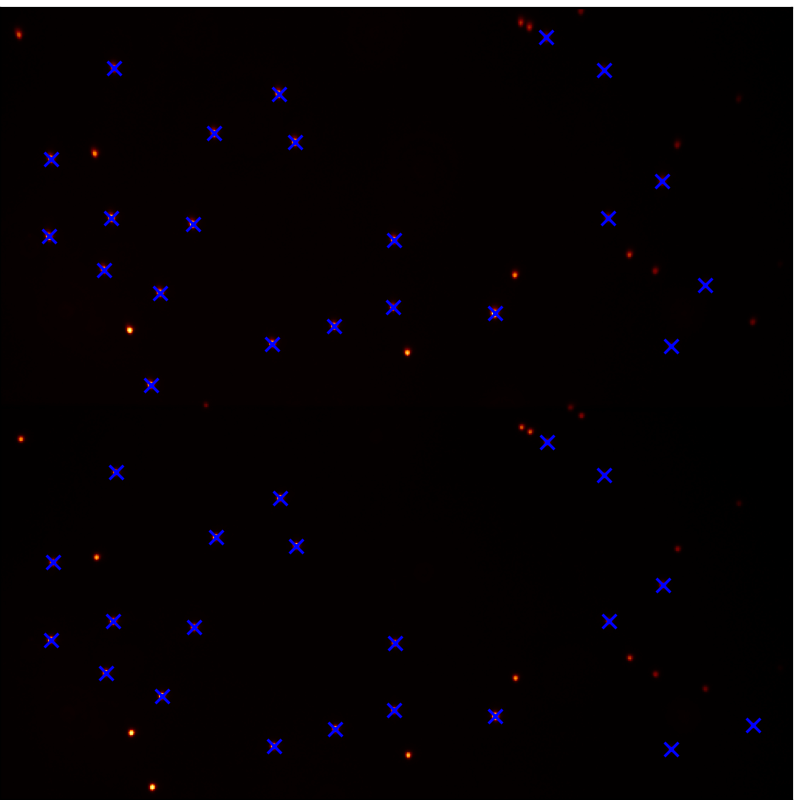

interactive(children=(IntSlider(value=0, description='n', max=199), Output()), _dom_classes=('widget-interact'…

In [39]:
# Explore all frames
fig4, ax4 = plt.subplots(figsize=(4, 4), gridspec_kw={'left':0, 'bottom':0, 'top':0.99, 'right':0.99})

im_data = ax4.imshow(img_stack[0], vmax=img_stack[0].max()*1.15)
peaks_line, = ax4.plot(*abs_pos[0].T, 'x', color='b', markerfacecolor='None', markersize=5)

def update(n):
    im_data.set_data(img_stack[n])
    peaks_line.set_data( *abs_pos[n].T )
    fig4.canvas.draw_idle()

ipw.interact(update, n=ipw.IntSlider(min=0, max=img_stack.shape[0]-1, step=1));

plt.imsave('EMCCD_melted_psf.png', img_stack[0], cmap='gray')

## Relative distances beads position to each other

In [40]:
all_pairs = abs_pos_nm[:, None, :, :] - abs_pos_nm[:, :, None, :] 
distances_with_duplicates = np.linalg.norm( all_pairs, axis=-1 )

triu_indices = np.triu_indices_from( distances_with_duplicates[0], k=1 )
distances_no_duplicates = distances_with_duplicates[:, triu_indices[0], triu_indices[1]]
distances_no_duplicates = distances_no_duplicates.T

In [42]:
def plot_distances(n):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
    
    # Histogram
    data = distances_no_duplicates[n] - distances_no_duplicates[n].mean()
    ax1.hist(data, bins=10, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    
    # Calculate mean and standard deviation
    mu, sigma = np.mean(data), np.std(data)
    
    # Gaussian curve
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax1.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2)), color='red', linewidth=2)
    
    # Plot the raw data
    center_value = np.mean(traces[n])
    line, = ax2.plot(traces[n], 'k')
    center_line = ax2.axhline(y=center_value, color='red', linestyle='--', label='Center Line')
    
    # Set titles and labels
    ax1.set_title(f'Histogram of Distances for Bead Pair {n}')
    ax1.set_xlabel('Distance (nm)')
    ax1.set_ylabel('Frequency')
    ax1.legend(['Gaussian', 'Histogram'], loc='upper right')
    
    ax2.set_title(f'Distances for Bead Pair {n}')
    ax2.set_xlabel('Frames')
    ax2.set_ylabel('Distance (nm)')
    
    plt.tight_layout()
    plt.show()

# Create slider widget for selecting the value of n
n_slider = ipw.IntSlider(min=0, max=distances_no_duplicates.shape[0]-1, step=1, value=10)

# Define callback function to update plot when slider value changes
def update_plot(n):
    plot_distances(n)

# Link slider widget to callback function
ipw.interact(update_plot, n=n_slider)

interactive(children=(IntSlider(value=10, description='n', max=902), Output()), _dom_classes=('widget-interact…

<function __main__.update_plot(n)>

# Mortensen distances

In this section, Mortensen's precision is defined using the function `mortensen_precision`, which calculates the localization precision based on specified parameters such as the PSF standard deviation (`sigma_psf`), background standard deviation (`b_2`), photon count per localization (`N`), and a constant value for the Mortensen parameter `a` (set to 6500). The obtained precision is then used in the `convert_peak_fit_to_abs_position_nm_with_precision` function to add Gaussian noise to the absolute positions in nanometers. This function takes the peak coordinates and parameters obtained from Gaussian fitting, along with the pixel size in nanometers (`pixel_size_nm`) and the calculated precision. Gaussian noise is added to both the x and y positions using `np.random.normal`. The resulting absolute positions with added noise are stored in the `abs_pos_nm_with_precision` variable. Subsequently, the distances between all pairs of absolute positions with added precision are computed and stored in the `distances_no_duplicates_precision` variable. This matrix contains the distances between all pairs of beads with added Gaussian noise. The distances are computed using the `np.linalg.norm` function applied to the differences between all pairs of absolute positions. 


In [43]:
# Define Mortensen's precision
localization_precision = mortensen_precision(1, sigma_psf, b_2, N, 6500)

# Define function to convert peak fits to absolute positions in nanometers
def convert_peak_fit_to_abs_position_nm_with_precision(peak, param, pixel_size_nm, precision):
    x_pos, y_pos = param[:, 0], param[:, 2]
    abs_pos_x = (peak[1] + x_pos) * pixel_size_nm
    abs_pos_y = (peak[0] + y_pos) * pixel_size_nm
    abs_pos_x_with_precision = abs_pos_x + np.random.normal(0, precision, size=abs_pos_x.shape)
    abs_pos_y_with_precision = abs_pos_y + np.random.normal(0, precision, size=abs_pos_y.shape)
    return abs_pos_x_with_precision, abs_pos_y_with_precision

abs_pos_nm_with_precision = [convert_peak_fit_to_abs_position_nm_with_precision(peak, params, pixel_size_nm, localization_precision) 
                             for peak, params in zip(peaks, param_each_bead)]

abs_pos_nm_with_precision = np.array([np.array(i).T for i in abs_pos_nm_with_precision])
abs_pos_nm_with_precision = np.moveaxis(abs_pos_nm_with_precision, 0, 1)

print(f"Absolute Positions with Mortensen's precision (nm):", abs_pos_nm_with_precision)

Absolute Positions with Mortensen's precision (nm): [[[127630.8151499263  78780.344148407 ]
  [ 41219.6523612651  73452.4661693472]
  [ 28584.6767202215  54079.649659934 ]
  ...
  [182122.3286316404  71545.0807146011]
  [194530.3832149729 185260.546671738 ]
  [173320.2981188333 191411.7609938607]]

 [[127692.0249906365  78782.5318689723]
  [ 41241.2593909248  73503.4048044166]
  [ 28570.1235701522  54103.4383357953]
  ...
  [182105.6879993534  71575.7344049071]
  [194476.5754929069 185273.4483239147]
  [173390.459668902  191405.2272952241]]

 [[127666.1528357953  78730.3841770955]
  [ 41160.7453798412  73389.6988890035]
  [ 28569.8304596634  54020.6027139328]
  ...
  [182150.6688319325  71506.1885925526]
  [194468.5522532989 185236.1198709906]
  [173290.0916053501 191455.3762080979]]

 ...

 [[127604.7711898557  78750.1144124887]
  [ 41209.0328923416  73467.2453646552]
  [ 28492.9045371474  54027.684360028 ]
  ...
  [182112.5626968489  71613.5888069505]
  [194441.8668157189 185248.8282

In [44]:
all_pairs = abs_pos_nm_with_precision[:, None, :, :] - abs_pos_nm_with_precision[:, :, None, :] 
distances_with_duplicates_precision = np.linalg.norm( all_pairs, axis=-1 )

triu_indices = np.triu_indices_from( distances_with_duplicates_precision[0], k=1 )
distances_no_duplicates_precision = distances_with_duplicates_precision[:, triu_indices[0], triu_indices[1]]
distances_no_duplicates_precision = distances_no_duplicates_precision.T
print(distances_no_duplicates_precision)

[[ 86575.2582337948  86611.8009011475  86670.1127175168 ...
   86557.1042800596  86598.7823095623  86756.0779110682]
 [102079.6838065692 102147.9759898918 102130.575286892  ...
  102148.7183428312 102073.9830508545 102155.3497705517]
 [104150.182075055  104186.7107766579 104234.9064103788 ...
  104280.2238785491 104254.6313631238 104174.0869193688]
 ...
 [114390.4148798828 114368.741392859  114395.0502451072 ...
  114302.1407731386 114375.8047379399 114447.9260859579]
 [120189.4204259203 120146.0052236546 120276.0052480024 ...
  120114.0977637097 120198.3074084084 120293.6146498376]
 [ 22084.0473514745  21959.5763596738  22072.7511833792 ...
   21964.8392263394  22089.0358167333  22038.6495125636]]


# Summary Statistics


This section computes summary statistics and visualizations for the bead pair distances. It starts by calculating the variance of the distances between bead pairs and then derives the single-variance values. These metrics are used to generate a summary statistics DataFrame (`stats_data`) containing mean distance, standard deviation, variance, and single-bead variance for each bead pair. The DataFrame is displayed and saved as a CSV file. 

Next, a function `plot_distances` is defined to visualize the distances for a selected bead pair. It creates a histogram of the distances, calculates the theoretical precision vs the experimental precision.

Then, another DataFrame (`Bead_pair_data`) is constructed to store bead pair distances in micrometers along with theoretical and experimental localization precision (in nanometers). This DataFrame is displayed and saved as a CSV file as well.


In [46]:
# Assuming var(bead pair) is symmetric for both beads
var_distances = np.var(distances_no_duplicates, axis=1)
single_var = np.sqrt((var_distances**2)/2)

data = {
    'Mean Distance (nm)': np.mean(distances_no_duplicates, axis=1),
    'Standard Deviation': np.std(distances_no_duplicates, axis=1),
    'Variance': np.var(distances_no_duplicates, axis=1),
    'Variance single bead distances (nm)': single_var
}

stats_data = pd.DataFrame(data)

display(stats_data)
np.sqrt(np.mean(single_var))

,Mean Distance (nm),Standard Deviation,Variance,Variance single bead distances (nm)
0,86652.726562,2.523682,6.368968,4.503541
1,102112.960938,2.271877,5.161424,3.649678
2,104197.789062,4.117872,16.956869,11.990317
3,81456.726562,2.186954,4.782766,3.381927
4,126766.109375,2.686307,7.216246,5.102656
...,...,...,...,...
898,100296.023438,4.596692,21.129578,14.940867
899,104194.929688,4.324323,18.699772,13.222735
900,114364.578125,4.940131,24.404896,17.256866
901,120184.500000,4.630799,21.444298,15.163408


2.9186435

In [47]:
def plot_distances(n):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
    
    # Histogram
    data = distances_no_duplicates[n] - distances_no_duplicates[n].mean()
    ax1.hist(data, bins=10, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    
    # Calculate mean and standard deviation
    mu, sigma = np.mean(data), np.std(data)
    
    var_distances = np.var(distances_no_duplicates[n])
    single_var = np.sqrt(var_distances**2 / 2)
    
    # Gaussian curve
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax1.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2)), color='red', linewidth=2)
    
    # Plot the raw data
    center_value = np.mean(traces[n])
    line, = ax2.plot(traces[n], 'k')
    center_line = ax2.axhline(y=center_value, color='red', linestyle='--', label='Center Line')
    ax2.plot(np.arange(len(traces[n])), np.full_like(traces[n], center_value + single_var), color='blue', linestyle='--', label=f'Estimated error')  # Plotting single_var above the center point
    ax2.plot(np.arange(len(traces[n])), np.full_like(traces[n], center_value - single_var), color='blue', linestyle='--')  # Plotting single_var below the center point
    error_propagation = error_propagation_triangular[n]  # Extract uncertainties for the current bead pair
    ax2.plot(np.arange(len(traces[n])), np.full_like(traces[n], center_value + error_propagation/2), color='green', linestyle='--')
    ax2.plot(np.arange(len(traces[n])), np.full_like(traces[n], center_value - error_propagation/2), color='green', linestyle='--',label=f'Localisation precision')  # Plotting error propagation below the center line

    # Set titles and labels
    ax1.set_title(f'Histogram of Distances for Bead Pair {n}')
    ax1.set_xlabel('Distance (nm)')
    ax1.set_ylabel('Frequency')
    ax1.legend(['Gaussian', 'Histogram'], loc='upper right')
    
    ax2.set_title(f'Distances for Bead Pair {n}')
    ax2.set_xlabel('Frames')
    ax2.set_ylabel('Distance (nm)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Create slider widget for selecting the value of n
n_slider = ipw.IntSlider(min=0, max=distances_no_duplicates.shape[0]-1, step=1, value=10)

# Define callback function to update plot when slider value changes
def update_plot(n):
    plot_distances(n)

# Link slider widget to callback function
ipw.interact(update_plot, n=n_slider)


interactive(children=(IntSlider(value=10, description='n', max=902), Output()), _dom_classes=('widget-interact…

<function __main__.update_plot(n)>

In [48]:
data = {
    'Bead-Pair Distances (um)': np.mean(distances_no_duplicates/1000, axis=1),
    'Bead-Pair index' : np.arange(0,903,1),
    'Theoretical localisation precision (nm)': error_propagation_triangular,
    'Experimental localisation precision (nm)': single_var
}

Bead_pair_data = pd.DataFrame(data)

display(Bead_pair_data)
stats_data.to_csv('Bead_pair_data.csv', index=False)

,Bead-Pair Distances (um),Bead-Pair index,Theoretical localisation precision (nm),Experimental localisation precision (nm)
0,86.652733,0,4.622464,4.503541
1,102.112961,1,4.661648,3.649678
2,104.197784,2,4.705016,11.990317
3,81.456726,3,4.631286,3.381927
4,126.766113,4,4.524322,5.102656
...,...,...,...,...
898,100.296013,898,4.239162,14.940867
899,104.194923,899,4.220234,13.222735
900,114.364571,900,4.266670,17.256866
901,120.184502,901,4.247865,15.163408


## Precision Comparison

This code snippet generates visualizations to compare experimental and theoretical localization precision for bead pairs. It first plots both experimental and theoretical precision against the bead-pair index on a single graph.

Next, the code filters out rows from the DataFrame where the experimental localization precision exceeds a specified threshold (25 nm). The resulting filtered data is then plotted similarly to the previous graph, with the legend labels "Experimental Precision" and "Theoretical Precision" remaining applicable.

Finally, the code calculates and plots the factor difference between experimental and theoretical precision. The legend label "Difference" should be replaced with a suitable description reflecting the nature of the factor difference being visualized.

To adapt this code for your own dataset, replace the legend labels with appropriate descriptors.

<IPython.core.display.Javascript object>


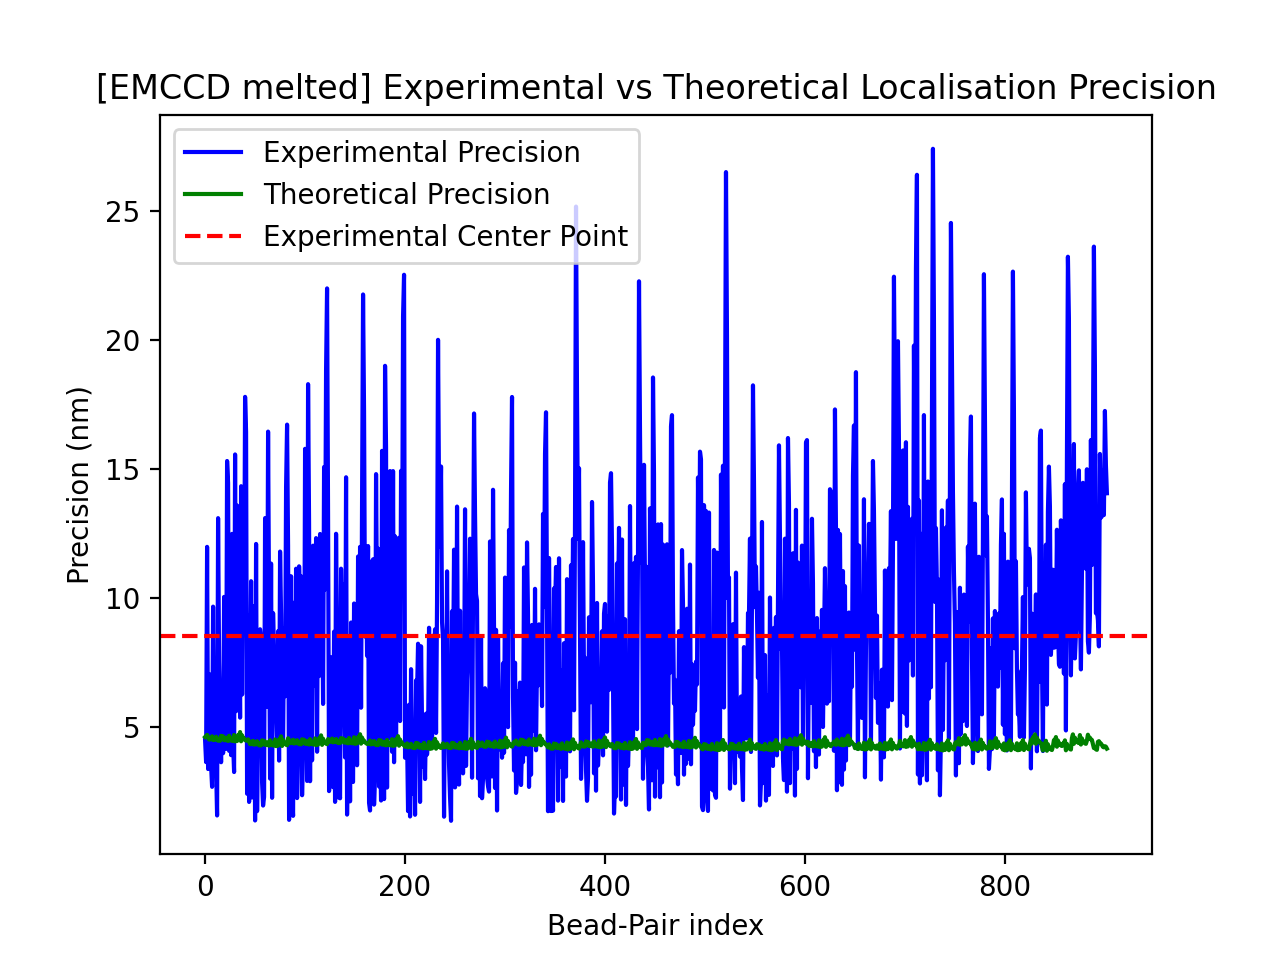

In [30]:
experimental_center_point = Bead_pair_data['Experimental localisation precision (nm)'].mean()  # or .median()

fig, ax = plt.subplots()
Bead_pair_data.plot(x='Bead-Pair index', y='Experimental localisation precision (nm)', color='blue', ax=ax, label='Experimental Precision')
Bead_pair_data.plot(x='Bead-Pair index', y='Theoretical localisation precision (nm)', color='green', ax=ax, label='Theoretical Precision')
ax.axhline(y=experimental_center_point, color='red', linestyle='--', label='Experimental Center Point')

plt.xlabel('Bead-Pair index')
plt.ylabel('Precision (nm)')
plt.title('[EMCCD melted] Experimental vs Theoretical Localisation Precision')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


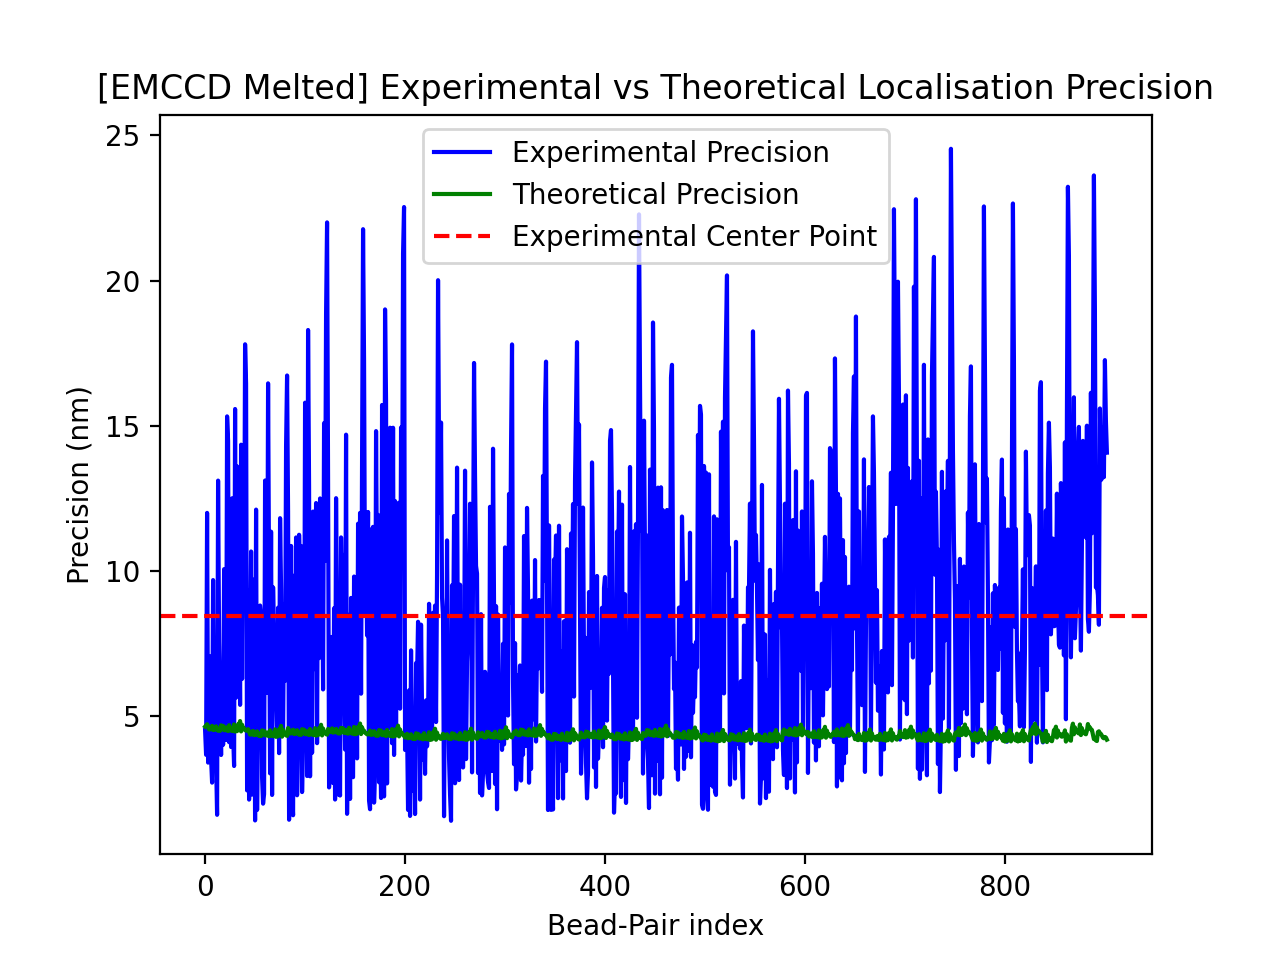

Average Experimental Precision 8.439021
Average Theoretical Precision 4.348718761006644


In [49]:
def remove_rows_above_threshold(df, column_name, threshold):
    return df.loc[df[column_name] <= threshold]

filtered_data = remove_rows_above_threshold(Bead_pair_data, 'Experimental localisation precision (nm)', 25)
experimental_center_point = filtered_data['Experimental localisation precision (nm)'].mean()  # or .median()

filtered_data 
fig, ax = plt.subplots()

filtered_data.plot(x='Bead-Pair index', y='Experimental localisation precision (nm)', color='blue', ax=ax, label='Experimental Precision')
filtered_data.plot(x='Bead-Pair index', y='Theoretical localisation precision (nm)', color='green', ax=ax, label='Theoretical Precision',linestyle='-') 
ax.axhline(y=experimental_center_point, color='red', linestyle='--', label='Experimental Center Point')
plt.xlabel('Bead-Pair index')
plt.ylabel('Precision (nm)')
plt.title('[EMCCD Melted] Experimental vs Theoretical Localisation Precision')
plt.legend()
plt.savefig('emccd_melted_exp_vs_the.png', format='png', dpi=300)
plt.show()

print("Average Experimental Precision", experimental_center_point)
print("Average Theoretical Precision", filtered_data['Theoretical localisation precision (nm)'].mean())

<IPython.core.display.Javascript object>


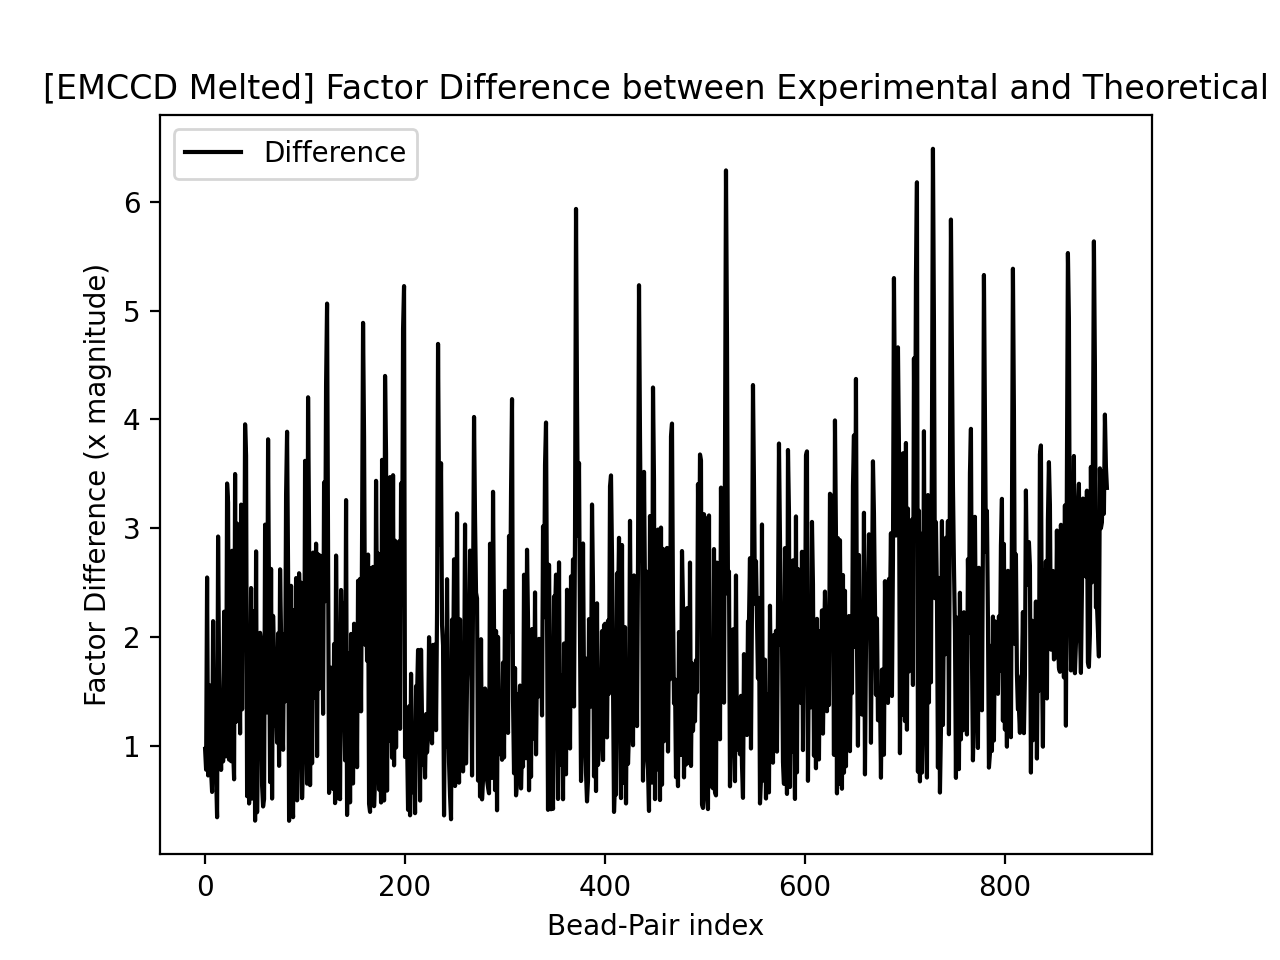

In [32]:
#plot difference between experimental and theoretical
difference = single_var/error_propagation_triangular

fig2, ax1 = plt.subplots()

ax1.plot(Bead_pair_data['Bead-Pair index'], difference, color='black', label='Difference')
plt.xlabel('Bead-Pair index')
plt.ylabel('Factor Difference (x magnitude)')  # Update ylabel to reflect difference
plt.title('[EMCCD Melted] Factor Difference between Experimental and Theoretical')
plt.legend()
plt.savefig('emccd_melted_diff.png', format='png', dpi=300)
plt.show()